In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Load the data and code from Github 

In [32]:
!git clone https://github.com/Eslam21/ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset.git

Cloning into 'ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset'...
remote: Enumerating objects: 447, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 447 (delta 2), reused 0 (delta 0), pack-reused 438 (from 1)
Receiving objects: 100% (447/447), 1.04 GiB | 10.25 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (195/195), done.


### Rename the folder

In [33]:
import os

# Define the current and new directory paths
current_directory = '/kaggle/working/ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset'
new_directory = '/kaggle/working/ArEEG'

# Rename the directory
os.rename(current_directory, new_directory)

# Verify if the rename was successful
if os.path.exists(new_directory):
    print(f"Directory renamed to {new_directory}")
else:
    print("Renaming failed.")


Directory renamed to /kaggle/working/ArEEG


In [34]:
!pwd
!cd ArEEG
!ls

/kaggle/working
ArEEG


In [37]:
from ArEEG.Utilities.Extractor import process_eeg
import os
from concurrent.futures import ProcessPoolExecutor

def LoadAllSubjectsCSV(full_dataset_path: str = 'CSVData'):
    """
    Load all subject data from CSV files.

    Parameters: dataset folder path
    """
    results = []
    with ProcessPoolExecutor(4) as executor:
        for subject in os.listdir(full_dataset_path):
            results.append(executor.submit(process_eeg, subject_folder=os.path.join(full_dataset_path,subject)))

    for result in results:
        yield result.result()

In [46]:

import os
from concurrent.futures import ProcessPoolExecutor

def LoadAllSubjectsCSV(full_dataset_path: str = 'CSVData'):
    """
    Load all subject data from CSV files.

    Parameters: dataset folder path
    """
    results = []
    with ProcessPoolExecutor(4) as executor:
        for subject in os.listdir(full_dataset_path):
            results.append(executor.submit(process_eeg, subject_folder=os.path.join(full_dataset_path,subject)))

    for result in results:
        yield result.result()



### Extracting each subject data independently 

for example here subject1 data is extracted

**Notes about process_eeg function:**

- The function reads CSV files from the specified subject folder.
- Each CSV file is expected to contain columns 'EEG 1' to 'EEG 8' for EEG channels and 'State' for the state labels.
- The function groups the EEG data by state transitions and extracts segments of length TIME_STEPS.
- TIME_STEPS (int) is the number of time steps for each EEG data segment. Default is 1200.
- If a segment is shorter than TIME_STEPS, it is padded with zeros.
- The function ensures that all extracted segments have the same shape.
- If there are inconsistent shapes, the function filters out those segments and only retains the consistent ones.

In [63]:
TIME_STEPS = 1200
included_states = ["Up", "Down", "Left", "Right", "Select"]

X, Y = process_eeg(TIME_STEPS=TIME_STEPS, included_states=included_states, subject_folder="/kaggle/working/ArEEG/CSVData/Subject1")
print("Data shape: [trials x channels x samples]")
print(X.shape) # Trials, channels, samples

print("Labels shape")
print(Y.shape) # class

Data shape: [trials x channels x samples]
(375, 8, 1200)
Labels shape
(375,)


### Extraction of all subjects into one array

In [65]:
# get all folders in the path
directory="/kaggle/working/ArEEG/CSVData"
folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
print("Number of Subjects:",len(folders))

Number of Subjects: 12


In [64]:
from ArEEG.Utilities.Extractor import process_eeg

X= []
Y= []

TIME_STEPS = 1200
included_states = ["Up", "Down", "Left", "Right", "Select"]

# Process each folder
for folder in folders:
    subject_folder = os.path.join(directory, folder)
    print("Working on Subject:", folder, "with", len(os.listdir(directory + '/' + folder)), "Trials")

    # Process the EEG data (replace with your actual function and its arguments)
    x, y = process_eeg(TIME_STEPS=TIME_STEPS, included_states=included_states, subject_folder=subject_folder)
    X.append(x)
    Y.append(y)

    
# concatenate all subjects data 
X= np.concatenate(X)
Y= np.concatenate(Y)

Working on Subject: Subject1 with 15 Trials
Working on Subject: Subject0 with 15 Trials
Working on Subject: Subject8 with 15 Trials
Working on Subject: Subject9 with 15 Trials
Working on Subject: Subject2 with 15 Trials
Working on Subject: Subject11 with 15 Trials
Working on Subject: Subject5 with 15 Trials
Working on Subject: Subject4 with 15 Trials
Working on Subject: Subject3 with 21 Trials
Working on Subject: Subject6 with 15 Trials
Working on Subject: Subject7 with 15 Trials
Working on Subject: Subject10 with 15 Trials


In [84]:
X.shape

(4589, 8, 1200)

In [85]:
Y.shape

(4589,)

### Plotting the mean of all trials

In [106]:
n = X.mean(axis=0)
n.shape

(8, 1200)

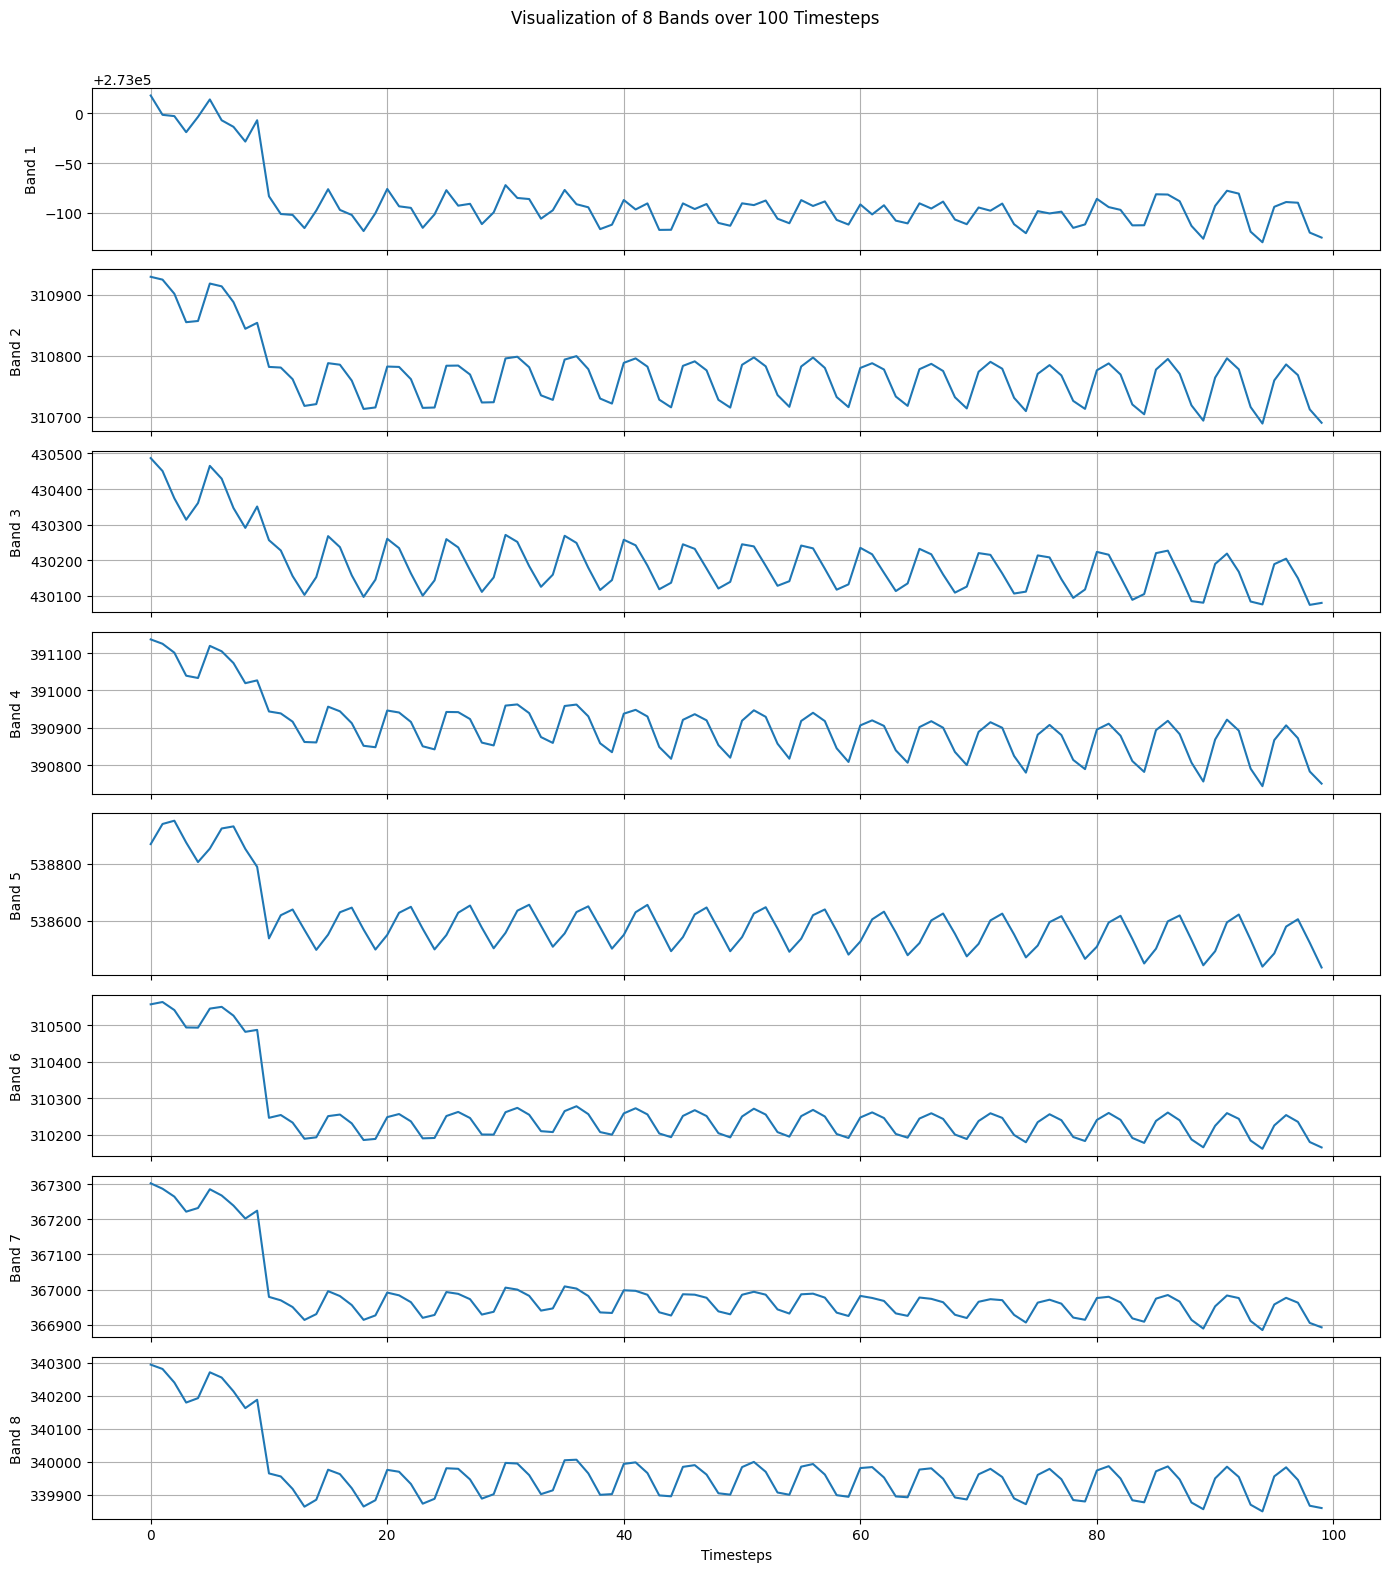

In [109]:
import matplotlib.pyplot as plt


ts = 100
# Define the timesteps
timesteps = np.arange(ts)

# Create a figure and an array of subplots with 8 rows and 1 column
fig, axes = plt.subplots(8, 1, figsize=(14, 16), sharex=True)

# Plot each band in a separate subplot
for band in range(n.shape[0]):
    axes[band].plot(timesteps, n[band, :ts])
    axes[band].set_ylabel(f'Band {band+1}')
    axes[band].grid(True)

# Add a common x-axis label
axes[-1].set_xlabel('Timesteps')

# Add a common title
fig.suptitle('Visualization of 8 Bands over 100 Timesteps')

# Adjust the layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Show the plot
plt.show()